In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.4f}'.format)
plt.style.use('ggplot')

In [3]:
url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/E-commerce%20Customer%20Behavior%20-%20Sheet1.csv"
df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (350, 11)


,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,"1,120.2000",14,4.6000,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.5000,11,4.1000,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.7500,9,3.4000,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,"1,480.3000",19,4.7000,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.4000,13,4.0000,True,55,Unsatisfied


In [4]:
satisfaction_map = {'Unsatisfied': 0, 'Neutral': 1, 'Satisfied': 2}
df['Satisfaction_Numeric'] = df['Satisfaction Level'].map(satisfaction_map)

df['Discount_Numeric'] = df['Discount Applied'].astype(int)

df['Gender_Numeric'] = df['Gender'].map({'Male': 0, 'Female': 1})

features_list = [
    'Age', 
    'Items Purchased', 
    'Average Rating', 
    'Days Since Last Purchase', 
    'Satisfaction_Numeric', 
    'Discount_Numeric', 
    'Gender_Numeric'
]
target = 'Total Spend'

X = df[features_list]
y = df[target]

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features_list)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features_list)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features_list)

print("Preprocessing Complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Preprocessing Complete.
Training samples: 280
Testing samples: 70


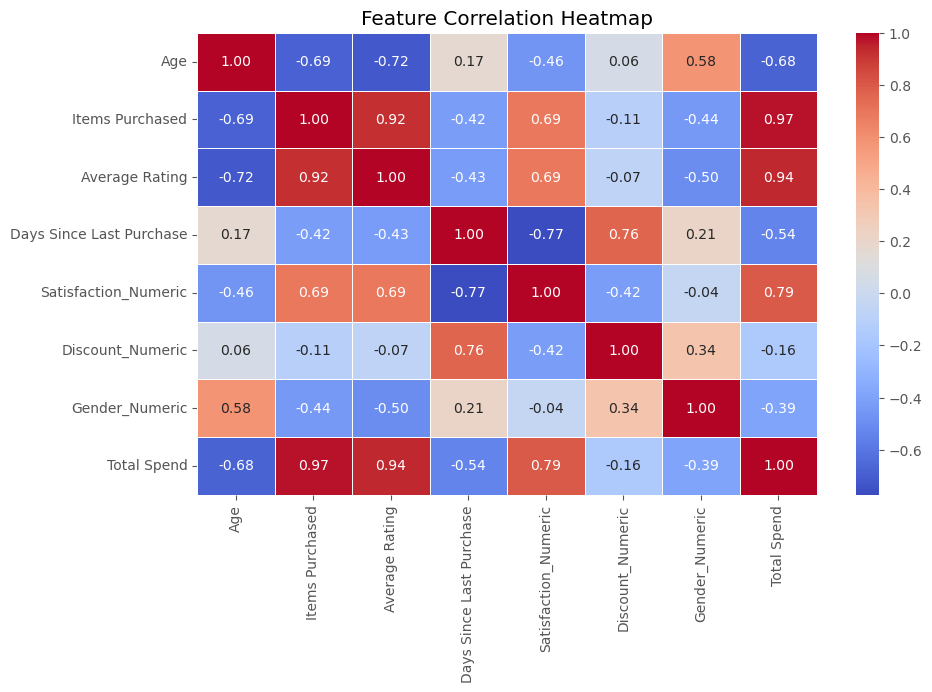

In [5]:
plt.figure(figsize=(10, 6))
heatmap_data = pd.concat([X_imputed, y], axis=1)
corr_matrix = heatmap_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_df, y_train)
y_pred_lr = lr_model.predict(X_test_scaled_df)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled_df, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled_df)

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled_df, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled_df)

print("Linear models trained.")

Linear models trained.


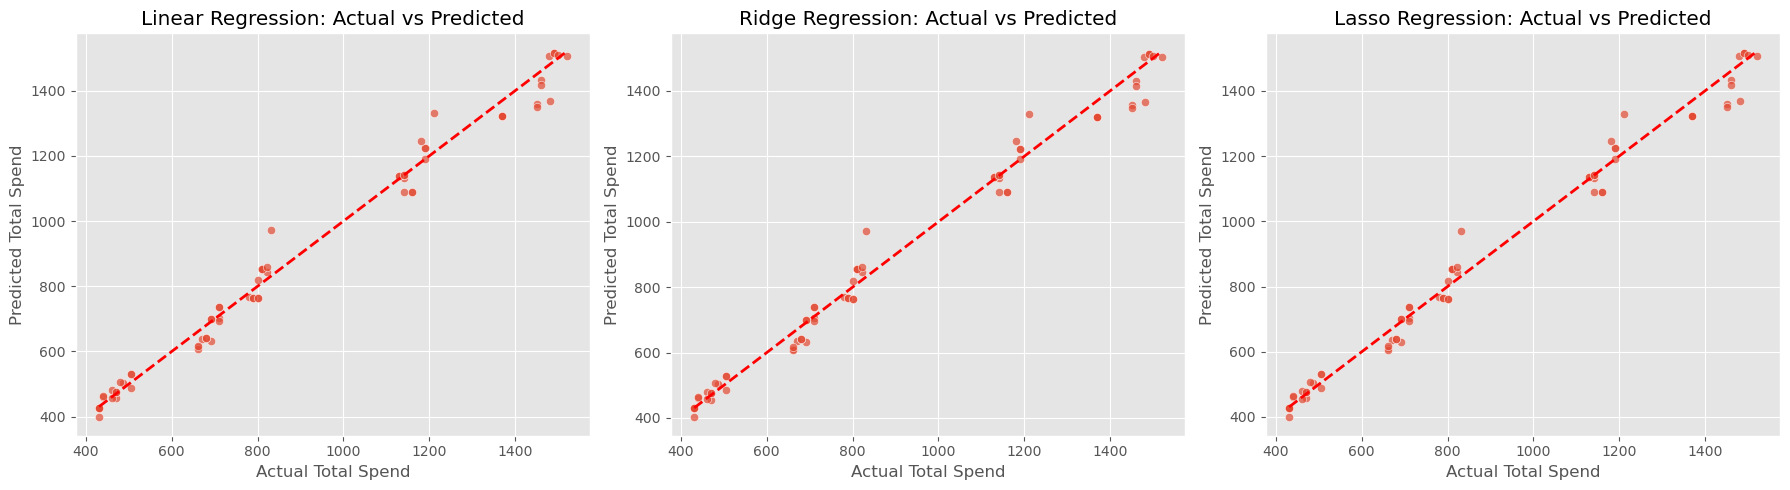

In [7]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.7)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Total Spend')
plt.ylabel('Predicted Total Spend')
plt.title('Linear Regression: Actual vs Predicted')

plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Total Spend')
plt.ylabel('Predicted Total Spend')
plt.title('Ridge Regression: Actual vs Predicted')

plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Total Spend')
plt.ylabel('Predicted Total Spend')
plt.title('Lasso Regression: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [8]:
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree trained.")

Decision Tree trained.


In [9]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

results = [
    evaluate_model("Linear Regression", y_test, y_pred_lr),
    evaluate_model("Ridge Regression", y_test, y_pred_ridge),
    evaluate_model("Lasso Regression", y_test, y_pred_lasso),
]

results_df = pd.DataFrame(results).set_index('Model')
print("--- Model Performance Leaderboard ---")
display(results_df.sort_values(by='RMSE'))

--- Model Performance Leaderboard ---


,MAE,RMSE,R2 Score
Model,,,
Linear Regression,33.0505,43.7092,0.9859
Lasso Regression,33.0954,43.7588,0.9858
Ridge Regression,32.8250,43.9469,0.9857


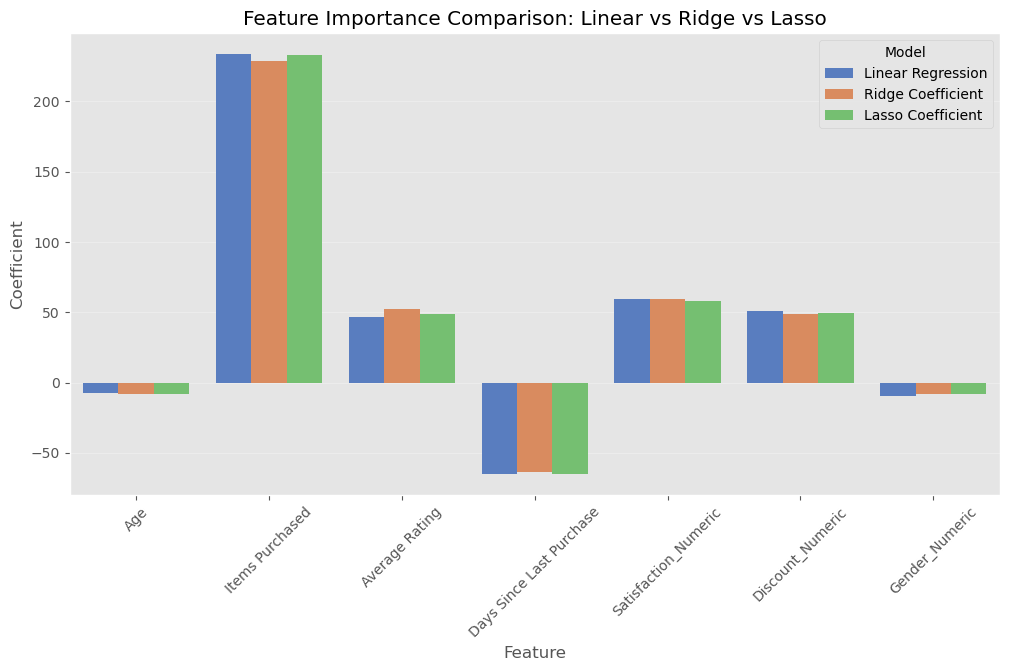

In [10]:
coef_data = {
    'Feature': features_list,
    'Linear Regression': lr_model.coef_,  # Added Linear Regression here
    'Ridge Coefficient': ridge_model.coef_,
    'Lasso Coefficient': lasso_model.coef_
}

coef_df = pd.DataFrame(coef_data)

coef_melted = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Coefficient', hue='Model', data=coef_melted, palette='muted')
plt.title("Feature Importance Comparison: Linear vs Ridge vs Lasso")
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.show()